## 필요한 패키지 다운

In [36]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')


In [37]:
# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [38]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(f"train : {len(train_filenames)}")
print(f"test: {len(test_filenames)}")
print(f"val : {len(val_filenames)}")

train : 5216
test: 624
val : 16


### val 데이터 셋이 너무 적어서 train과 합친뒤 8:2로 나눈다. 

In [39]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(f"train : {len(train_filenames)}")
print(f"val : {len(val_filenames)}")

train : 4185
val : 1047


### 정상과 폐렴 데이터의 불균형이 존재한다
- 추후 weight balancing 테크닉을 사용해서 가중치를 다르게 적용한다.

In [40]:
normal_count = pneumonia_count = 0

for filename in train_filenames:
    if "NORMAL" in filename:
        normal_count += 1
    else:
        pneumonia_count += 1
        
print(f"nomal : {normal_count}")
print(f"pneumonia : {pneumonia_count}")

nomal : 1072
pneumonia : 3113


### 필요한 함수 작성
- 라벨, 사이즈 수정, 이미지와 라벨 불러오는 함수

In [41]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)


def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img


# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### Tensorflow 파이프라인을 사용하기위해 dataset을 이용해야한다.
- 데이터 불러오기 (tf.data.Dataset.from_tensor_slices(x)
- 데이터 확인 tf.data.experimental.cardinality(x).numpy()

In [42]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [43]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 데이터 라벨과, 이미지 타입 수정 및 사이즈 수정
tf.data.experimental.AUTOTUNE
- tf.data 런타임 실행시에 동적으로 값을 조정하도록 만든다.

In [64]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 배치 사이즈
BATCH_SIZE = 16

In [45]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [46]:
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [47]:
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print(f"test images count: {TEST_IMAGE_COUNT}")

test images count: 624


### 파이프라인 이용해 데이터 준비

In [48]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균힐하게 한다음 요소를 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    # epoch을 진행하면서 여러 번 데이터셋을 불러오게 된다.
    ds = ds.repeat()
    # BATCH_SIZE 사이즈만큼 배치를 나누게 된다.
    ds = ds.batch(BATCH_SIZE)
    # 학습 데이터를 나눠서 읽어오기 때문에 데이터를 gpu에서 학습하는동안
    # 두번째 데이터를 cpu에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있따.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [49]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

In [97]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

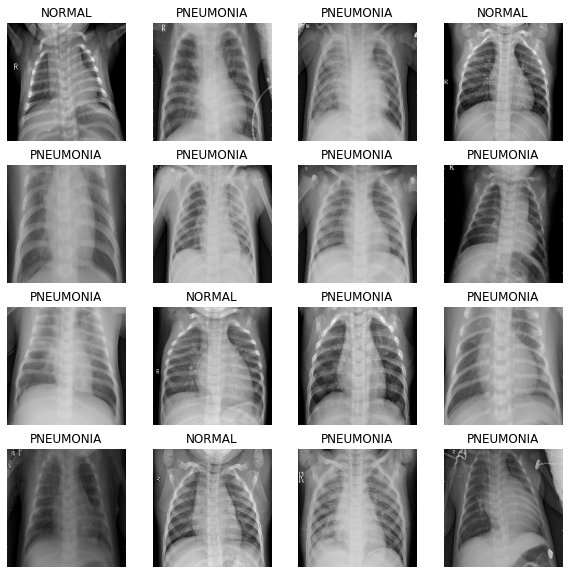

In [98]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 데이터 imbalance 처리

In [50]:
weight_for_normal = (1 / normal_count)*(TRAIN_IMG_COUNT)/2.0 
weight_for_pneumonia = (1 / pneumonia_count)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_normal, 1: weight_for_pneumonia}

print('Weight for NORMAL: {:.2f}'.format(weight_for_normal))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_pneumonia))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 모델 설계 및 학습

- 모델 설계에 사용될 블록 선언

In [51]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- 모델 설계

In [61]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

- 모델 선언

In [62]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- 모델 학습

In [51]:
EPOCHS = 25

In [45]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 89s 194ms/step - loss: 0.4015 - accuracy: 0.7941 - precision: 0.9562 - recall: 0.7580 - val_loss: 0.6109 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2490 - accuracy: 0.9021 - precision: 0.9704 - recall: 0.8958 - val_loss: 1.2102 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2108 - accuracy: 0.9186 - precision: 0.9750 - recall: 0.9141 - val_loss: 0.0953 - val_accuracy: 0.9712 - val_precision: 0.9803 - val_recall: 0.9803
Epoch 4/25
261/261 [==============================] - 51s 194ms/step - loss: 0.1705 - accuracy: 0.9330 - precision: 0.9790 - recall: 0.9298 - val_loss: 0.1440 - val_accuracy: 0.9433 - val_precision: 0.9958 - val_recall: 0.9268
Epoch 5/25
261/261 [==============================] - 53s 203ms/step - loss: 0.1687 - accura

- 결과 시각화

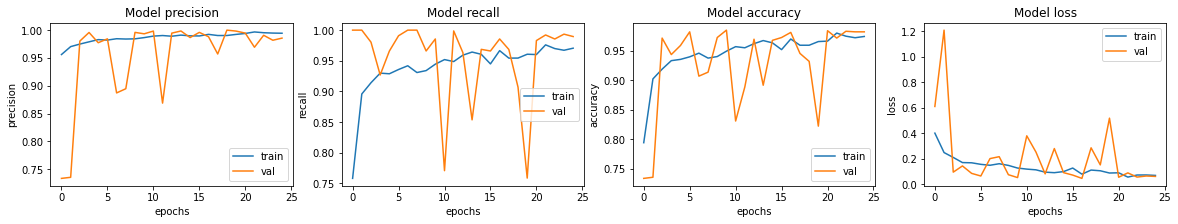

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 평가

In [48]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 116ms/step - loss: 1.3882 - accuracy: 0.7564 - precision: 0.7196 - recall: 1.0000
Loss: 1.3882335424423218,
Accuracy: 0.7564102411270142,
Precision: 0.7195571660995483,
Recall: 1.0


### 데이터 증강전 모델 저장

In [52]:
model1_save_path = os.path.join(ROOT_PATH, 'chest_xray/model1')
model.save(model1_save_path)

INFO:tensorflow:Assets written to: /aiffel/aiffel/chest_xray/model1/assets


### 데이터 증강 (augmentation)

In [65]:
train_list_ds_aug = tf.data.Dataset.from_tensor_slices(train_filenames)
train_ds_aug = train_list_ds_aug.map(process_path, num_parallel_calls=AUTOTUNE)

val_list_ds_aug = tf.data.Dataset.from_tensor_slices(val_filenames)
val_ds_aug = val_list_ds_aug.map(process_path, num_parallel_calls=AUTOTUNE)

test_list_ds_aug = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds_aug = test_list_ds_aug.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_aug = test_ds.batch(BATCH_SIZE)

- 증강 관련 페이지  
[tensorflow augmentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing?hl=ko)

In [66]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [67]:
def prepare_for_training_augmentation(ds, shuffle_buffer_size=1000):
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [68]:
train_ds_aug = prepare_for_training_augmentation(train_ds_aug)
val_ds_aug = prepare_for_training_augmentation(val_ds_aug)

In [56]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

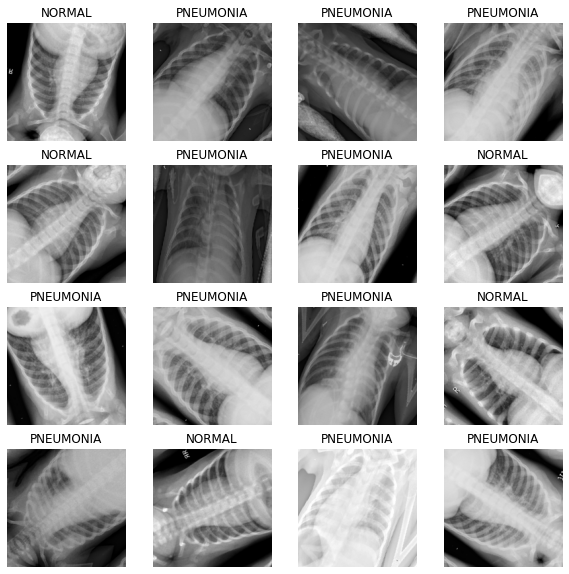

In [69]:
image_batch_aug, label_batch_aug = next(iter(train_ds_aug))
show_batch(image_batch_aug.numpy(), label_batch_aug.numpy())

- 모델선언

In [102]:
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- 모델 학습

In [103]:
EPOCHS = 25

In [105]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 67s 221ms/step - loss: 0.3047 - accuracy: 0.8685 - precision: 0.9678 - recall: 0.8517 - val_loss: 3.2011 - val_accuracy: 0.2692 - val_precision: 1.0000 - val_recall: 0.0013
Epoch 2/25
261/261 [==============================] - 56s 217ms/step - loss: 0.2941 - accuracy: 0.8764 - precision: 0.9669 - recall: 0.8636 - val_loss: 6.0565 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
261/261 [==============================] - 57s 220ms/step - loss: 0.2989 - accuracy: 0.8688 - precision: 0.9640 - recall: 0.8552 - val_loss: 3.2856 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 58s 222ms/step - loss: 0.2961 - accuracy: 0.8760 - precision: 0.9649 - recall: 0.8650 - val_loss: 2.7376 - val_accuracy: 0.2673 - val_precision: 1.0000 - val_recall: 0.0013
Epoch 5/25
261/261 [==============================] - 58s 223ms/step - loss: 0.2787 

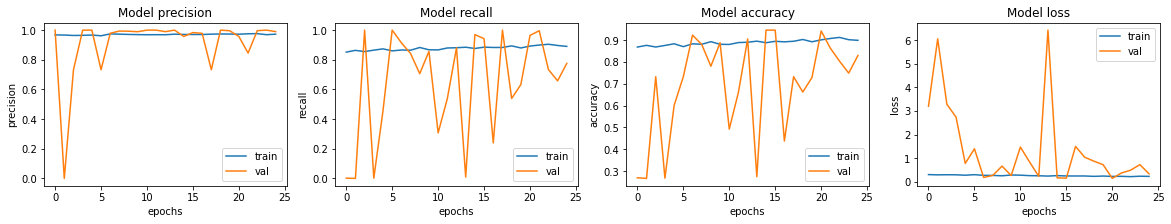

In [106]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [107]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 0.4197 - accuracy: 0.8125 - precision: 0.8934 - recall: 0.7949
Loss: 0.419715940952301,
Accuracy: 0.8125,
Precision: 0.8933717608451843,
Recall: 0.7948718070983887


In [113]:
model2_save_path = os.path.join(ROOT_PATH, 'chest_xray/model2')
model2.save(model2_save_path)

INFO:tensorflow:Assets written to: /aiffel/aiffel/chest_xray/model2/assets


### 이미지 augmentation 한 효과가 있었다.
acc 75% -> 81%

In [114]:
load_model1 = tf.keras.models.load_model(model1_save_path)
loss, accuracy, precision, recall = load_model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
print("============")
load_model2 = tf.keras.models.load_model(model2_save_path)
loss, accuracy, precision, recall = load_model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 1.3882 - accuracy: 0.7564 - precision: 0.7196 - recall: 1.0000
Loss: 1.3882335424423218,
Accuracy: 0.7564102411270142,
Precision: 0.7195571660995483,
Recall: 1.0
39/39 [==============================] - 5s 108ms/step - loss: 0.4197 - accuracy: 0.8125 - precision: 0.8934 - recall: 0.7949
Loss: 0.419715940952301,
Accuracy: 0.8125,
Precision: 0.8933717608451843,
Recall: 0.7948718070983887


### optimizer를 바꿔보자

In [115]:
with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='Nadam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [118]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 68s 214ms/step - loss: 0.4876 - accuracy: 0.7704 - precision: 0.9381 - recall: 0.7405 - val_loss: 0.6196 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 56s 213ms/step - loss: 0.3405 - accuracy: 0.8563 - precision: 0.9600 - recall: 0.8419 - val_loss: 1.1193 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 55s 212ms/step - loss: 0.2994 - accuracy: 0.8719 - precision: 0.9663 - recall: 0.8577 - val_loss: 0.2056 - val_accuracy: 0.9231 - val_precision: 0.9252 - val_recall: 0.9738
Epoch 4/25
261/261 [==============================] - 56s 214ms/step - loss: 0.2869 - accuracy: 0.8836 - precision: 0.9642 - recall: 0.8761 - val_loss: 0.3686 - val_accuracy: 0.8442 - val_precision: 0.8304 - val_recall: 0.9909
Epoch 5/25
261/261 [==============================] - 58s 221ms/step - loss: 0.2829 - accura

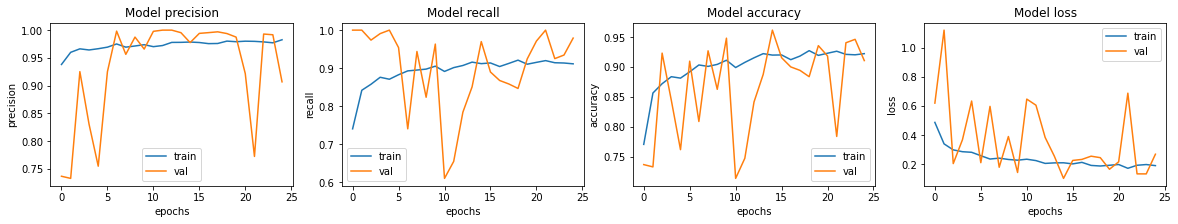

In [119]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [120]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.6955 - accuracy: 0.8061 - precision: 0.7739 - recall: 0.9744
Loss: 0.695494532585144,
Accuracy: 0.8060897588729858,
Precision: 0.7739307284355164,
Recall: 0.9743589758872986


- optimizer에는 별 변화가 없었다.

In [121]:
model3_save_path = os.path.join(ROOT_PATH, 'chest_xray/model3')
model3.save(model3_save_path)

INFO:tensorflow:Assets written to: /aiffel/aiffel/chest_xray/model3/assets


### lms에서 일반적으로 batchnomalization 과 drop 아웃을 같이 사용하지 않는다고 한다.
- dropout을 제거후 사용해보자

In [100]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

In [101]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [102]:
with tf.device('/GPU:0'):
    model4 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [103]:
with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 92s 306ms/step - loss: 0.3676 - accuracy: 0.8338 - precision: 0.9624 - recall: 0.8081 - val_loss: 0.6766 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 78s 301ms/step - loss: 0.2865 - accuracy: 0.8798 - precision: 0.9643 - recall: 0.8705 - val_loss: 1.3467 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 78s 300ms/step - loss: 0.2469 - accuracy: 0.8977 - precision: 0.9692 - recall: 0.8909 - val_loss: 0.2525 - val_accuracy: 0.8942 - val_precision: 0.8795 - val_recall: 0.9922
Epoch 4/25
261/261 [==============================] - 79s 303ms/step - loss: 0.2444 - accuracy: 0.9028 - precision: 0.9723 - recall: 0.8947 - val_loss: 0.1885 - val_accuracy: 0.9279 - val_precision: 0.9479 - val_recall: 0.9541
Epoch 5/25
261/261 [==============================] - 79s 304ms/step - loss: 0.2393 - accura

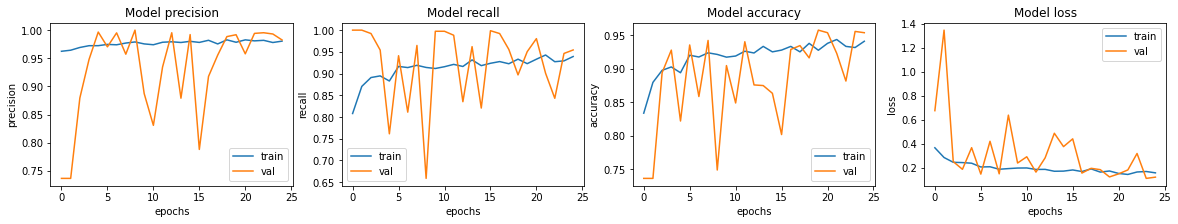

In [104]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [105]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 7s 169ms/step - loss: 0.3098 - accuracy: 0.8670 - precision: 0.8681 - recall: 0.9282
Loss: 0.309771329164505,
Accuracy: 0.8669871687889099,
Precision: 0.8681055307388306,
Recall: 0.928205132484436


In [106]:
model4_save_path = os.path.join(ROOT_PATH, 'chest_xray/model4')
model4.save(model4_save_path)

INFO:tensorflow:Assets written to: /aiffel/aiffel/chest_xray/model4/assets


### 최종 모델 비교

In [112]:
load_model1 = tf.keras.models.load_model(model1_save_path)
loss, accuracy, precision, recall = load_model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
print("============")
load_model2 = tf.keras.models.load_model(model2_save_path)
loss, accuracy, precision, recall = load_model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
print("============")
load_model3 = tf.keras.models.load_model(model3_save_path)
loss, accuracy, precision, recall = load_model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
print("============")
load_model4 = tf.keras.models.load_model(model4_save_path)
loss, accuracy, precision, recall = load_model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 7s 164ms/step - loss: 1.3874 - accuracy: 0.7564 - precision: 0.7196 - recall: 1.0000
Loss: 1.3873757123947144,
Accuracy: 0.7564102411270142,
Precision: 0.7195571660995483,
Recall: 1.0
39/39 [==============================] - 7s 163ms/step - loss: 0.4210 - accuracy: 0.8093 - precision: 0.8950 - recall: 0.7872
Loss: 0.42102697491645813,
Accuracy: 0.8092948794364929,
Precision: 0.8950437307357788,
Recall: 0.7871794700622559
39/39 [==============================] - 7s 164ms/step - loss: 0.6935 - accuracy: 0.8061 - precision: 0.7739 - recall: 0.9744
Loss: 0.6934739351272583,
Accuracy: 0.8060897588729858,
Precision: 0.7739307284355164,
Recall: 0.9743589758872986
39/39 [==============================] - 7s 162ms/step - loss: 0.3098 - accuracy: 0.8670 - precision: 0.8681 - recall: 0.9282
Loss: 0.309771329164505,
Accuracy: 0.8669871687889099,
Precision: 0.8681055307388306,
Recall: 0.928205132484436


- model1 : baseline model, acc 75%
- model2 : data augmentation, acc 80%
- model3 : change optimizer, acc 80%
- mode4 : dropout delete, acc 86%

## 회고

- 이번에는 모델을 빌드할때마다 모델을 설계하는 것이 아닌 함수를 선언해서 모델을 설계했다.  
그러다보니 익숙하지 않았지만, 모델 빌드를 하다보니 편했지만 grid serach를 이용해려다보니 어떻게할지 감이 안와서 난감했었다.  
- conv block과 dense block을 이용해서 새로운 레이어를 만들어서 사용한다는 점이 흥미로웠다.  
gpu를 사용하기 위해 사용한 방식도 잘 기억해두어야 겠다.
- 마지막으로 나온 결과는 마지막이 accuracy가 가장 높앗지만. 아무래도 암을 진단하는 모델이다보니, 폐렴인데 정상이라고 잘못 진단한 경우를 줄여야한다.  
따라서 precision = TP / (TP + FP) 값이 높은 MODEL2를 고려해보는것도 좋은듯 하다.
- 이번에도 dataset을 활용해봤지만 아직은 원하는대로 dataset을 다루지 못해서 좀 더 공부해야 겠다는 생각을 했다.  
- 추가적으로 하이퍼 파라미터를 찾을때 grid search를 고려해보았다. 하지만 익숙하지 않은 구조라 적용하는 것이 쉽지 않았다.  
그래서 tensorflow 홈페이지를 좀 찾아보니 파라미터 tuner라는것이 있었다.  
완벽하게 적용은 하지 못햇지만. 좀더 찾아봐서 적용해보도록 해야겠다.

### tensorflow tuner를 사용해보자
[Tensorflow Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko)  
! conda install -c conda-forge keras-tuner  
실습 환경에 설치하고 사용하면 된다.

In [96]:
import kerastuner as kt
import IPython

In [91]:
def build_model_tuner(hp):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    return model

In [92]:
tuner = kt.Hyperband(build_model_tuner,
                    objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3)

In [93]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [97]:
tuner.search(train_ds_aug,
             steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
             epochs = 10, 
             validation_data = val_ds_aug,
             validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
             class_weight=class_weight,
             callbacks = [ClearTrainingOutput()])

Trial 5 Complete [00h 03m 24s]
val_accuracy: 0.7615384459495544

Best val_accuracy So Far: 0.7615384459495544
Total elapsed time: 00h 13m 38s
INFO:tensorflow:Oracle triggered exit
